# Octree quantization

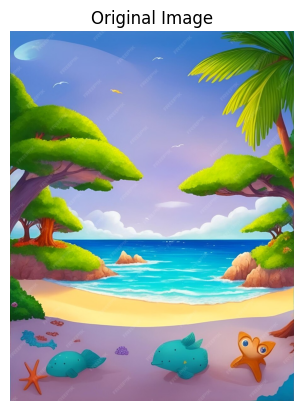

In [1]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from color import Color
from octree_quantizer import OctreeQuantizer
from skimage.measure import label, regionprops
from skimage.segmentation import find_boundaries
from skimage.morphology import opening, disk, remove_small_objects
import numpy as np


# Load the image
image = Image.open('../../test-images-mnz/beach_and_trees.jpg')

# Display the original image
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
plt.show()


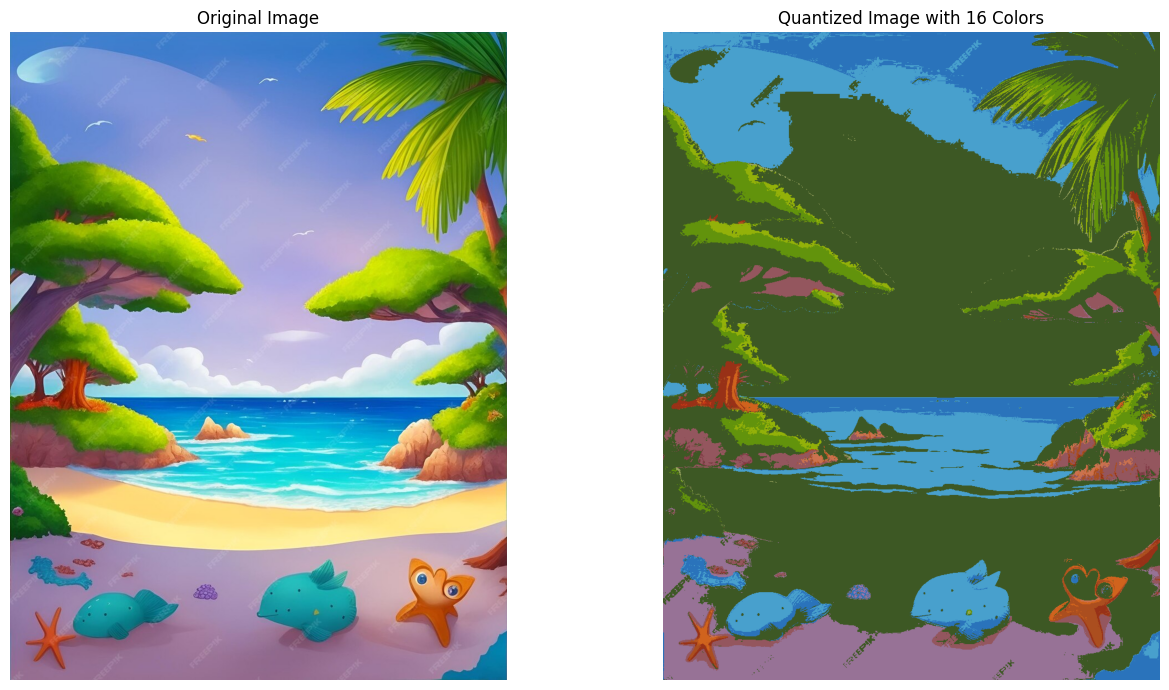

In [2]:
# Initialize the quantizer
quantizer = OctreeQuantizer()

# Get image data
pixels = image.load()
width, height = image.size

# Add colors to the octree
for y in range(height):
    for x in range(width):
        r, g, b = pixels[x, y]
        quantizer.add_color(Color(r, g, b))

# Define the number of colors for the palette
num_colors = 16
palette = quantizer.make_palette(num_colors)

# Create a new image with quantized colors
quantized_image = Image.new('RGB', (width, height))
quantized_pixels = quantized_image.load()

for y in range(height):
    for x in range(width):
        r, g, b = pixels[x, y]
        index = quantizer.get_palette_index(Color(r, g, b))
        color = palette[index]
        quantized_pixels[x, y] = (color.red, color.green, color.blue)

# Display the quantized image
fig, axes = plt.subplots(1, 2, figsize=(14, 7))  # 1 row, 2 columns

# Original image
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Quantized image
axes[1].imshow(quantized_image)
axes[1].set_title(f'Quantized Image with {num_colors} Colors')
axes[1].axis('off')

plt.tight_layout()
plt.show()


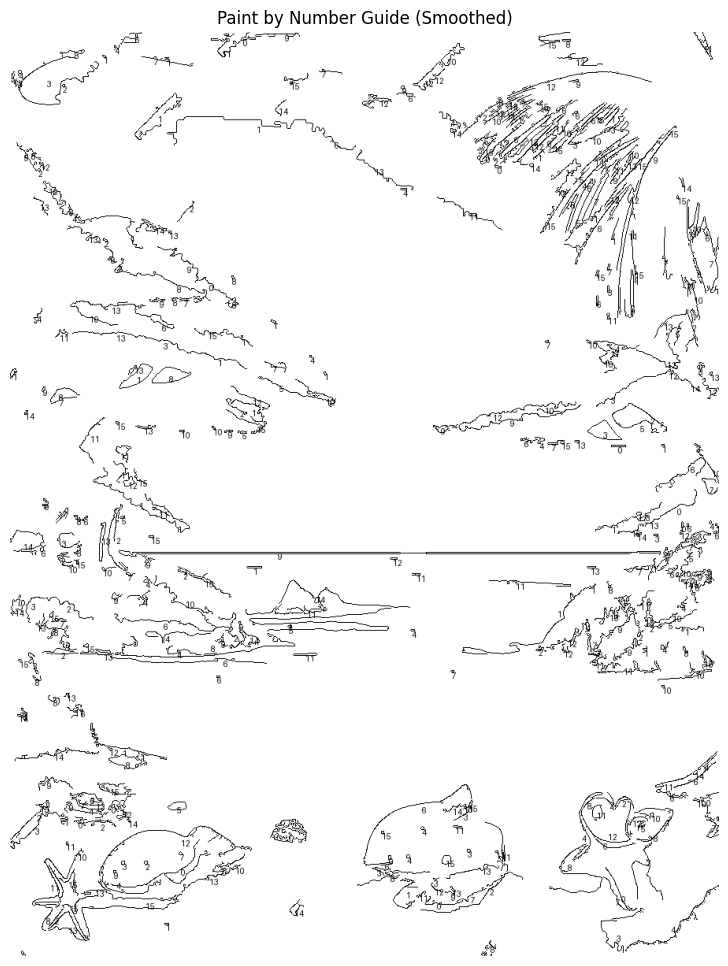

In [6]:
import cv2
import numpy as np
from PIL import Image, ImageDraw

def auto_canny_thresholds(gray_image, sigma=0.33):
    """Automatically determine Canny thresholds based on image content."""
    v = np.median(gray_image)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    return lower, upper


# Convert quantized image to grayscale (cv2 needs 8-bit)
gray = cv2.cvtColor(np.array(quantized_image), cv2.COLOR_RGB2GRAY)


# Get adaptive thresholds
lower, upper = auto_canny_thresholds(gray)

# 1. Canny Edge Detection
edges = cv2.Canny(gray, lower, upper)


# 2. Find Contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 3. Create white canvas
canvas = np.ones_like(gray) * 255  # white background

# 4. Filter and draw only large contours
min_area = 5  # adjust this value based on your scale
for cnt in contours:
    if cv2.contourArea(cnt) > min_area:
        cv2.drawContours(canvas, [cnt], -1, (0), 1)  # black line, 1px thick

# 5. Convert back to PIL image for numbering (optional)
paint_by_number_img = Image.fromarray(canvas).convert("RGB")
draw = ImageDraw.Draw(paint_by_number_img)

font = ImageFont.load_default()  # Or remove if default font is fine

for i, cnt in enumerate(contours):
    if cv2.contourArea(cnt) > min_area:
        M = cv2.moments(cnt)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            draw.text((cX, cY), str(i % num_colors), fill=(0, 0, 0))  # Numbering by color bucket

plt.figure(figsize=(12, 12))
plt.imshow(paint_by_number_img)
plt.title("Paint by Number Guide (Smoothed)")
plt.axis("off")
plt.show()
